In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14

import sys
import pandas as pd 

sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('/home/ychwang/jklib')


In [2]:

from jklib.genome import *
from jklib import REFERENCE



bases = ['A','T','C','G']
dna_dict = dict(zip(list('ATCG'),range(4)))
watsoncrick = {'N':'N','.':'.','C':'G','G':'C','A':'T','T':'A','*':'*'}




def add_base(li):
		"""Used in make_mer_list to add one more base to list"""
		new_li = []
		for s in li:
			for b in bases:
				new_li.append(s+b)
		return new_li

def make_mer_list(mer_len):
	"""Makes a list of all n-mers"""
	li = bases
	for i in range(mer_len-1):
		li = add_base(li)
	return li

def reverse_complement(seq):
    outseq = ''
    for s in seq:
        outseq = watsoncrick[s] + outseq
    return outseq

def hamdist(str1, str2):
   diffs = 0
   for ch1, ch2 in zip(str1, str2):
       if ch1 != ch2:
           diffs += 1
   return diffs
        
def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p

def make_mer_matrix_no_pos(seqs,mer_len):
    mer_dict = dict(zip(make_mer_list(mer_len),range(4**mer_len)))
    rows,cols = [],[]
    r = 0
    for i in xrange(len(seqs)):
        cur_seq = seqs[i]
        for b in range(len(cur_seq)-mer_len+1):
            rows.append(r)
            cols.append(mer_dict[cur_seq[b:b+mer_len]])
        if(r%10000)==0:
            print(r)
        r+=1
    vals = np.ones_like(cols)
    rows.append(r-1)
    cols.append(4**mer_len-1)
    vals = np.append(vals,0)
    X = scipy.sparse.csr_matrix((vals,(rows,cols)),dtype=np.float64)
    return X

def find_seq_diff_pos(wt_seq,mut_seq):
    """ Function to find the actual position of mutations based
    on the WT and MUT seq"""
    muts = np.zeros(len(wt_seq))
    for i in range(len(wt_seq)):
        muts[i] = (wt_seq[i]!=mut_seq[i])
    return find(muts)[0]

def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p


SNP_df =pd.read_excel('snp_data/only_changed_counts.xlsx')

In [3]:
def get_accuracy(predictions,data):
    accuracy = {'Correct':sum(sign(predictions)==sign(data)),
                'Incorrect':sum(sign(predictions)!=sign(data)),
                'Total':len(predictions),
                'Total_with_Change':sum(abs(data)>0),
                'R2':scipy.stats.pearsonr(predictions,data)[0]**2,
                'R2_P_value':scipy.stats.pearsonr(predictions,data)[1]}
    return accuracy

logit = lambda x: np.log(x)-np.log(1-x)
expit = lambda x: 1./(1.+np.exp(-x))

In [4]:
SNP_df.iloc[1950].EVENT

'chr1:36615115:36614693|36614938:-@chr1:36605670:36605767:-'

In [5]:
prediction_accuracy = {}
# Heterozygous SNPs in SDs:
SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HETERO_COUNTS>=2)&SNP_df.SS_MUT]
prediction_accuracy['SD_SNP_HETERO'] = get_accuracy(SNP_SD_HETERO.HETERO_DPSI_PRED,SNP_SD_HETERO.HETERO_DPSI)
prediction_accuracy['SD_SNP_HETERO_MAXENT'] = get_accuracy(SNP_SD_HETERO.MAXENT_EFFECT_SIZE,SNP_SD_HETERO.HETERO_DPSI)

# Heterozygous SNPs with large change in SDs:
SNP_SD_HETERO_LARGE = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HETERO_COUNTS>=2)&\
                             SNP_df.SS_MUT & SNP_df.LARGE_HETERO_EFFECT]
prediction_accuracy['SD_SNP_HETERO_LARGE'] = get_accuracy(SNP_SD_HETERO_LARGE.HETERO_DPSI_PRED,SNP_SD_HETERO_LARGE.HETERO_DPSI)
prediction_accuracy['SD_SNP_HETERO_LARGE_MAXENT'] = get_accuracy(SNP_SD_HETERO_LARGE.MAXENT_EFFECT_SIZE,SNP_SD_HETERO_LARGE.HETERO_DPSI)

# Homoozygous SNPs in SDs:
SNP_SD_HOMO = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HOMO_COUNTS>=2)&SNP_df.SS_MUT]
prediction_accuracy['SD_SNP_HOMO'] = get_accuracy(SNP_SD_HOMO.HETERO_DPSI_PRED,SNP_SD_HOMO.HETERO_DPSI)
prediction_accuracy['SD_SNP_HOMO_MAXENT'] = get_accuracy(SNP_SD_HOMO.MAXENT_EFFECT_SIZE,SNP_SD_HOMO.HETERO_DPSI)

# Homoozygous SNPs with large change in SDs:
SNP_SD_HOMO_LARGE = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HOMO_COUNTS>=2)&\
                             SNP_df.SS_MUT & SNP_df.LARGE_HOMO_EFFECT]
prediction_accuracy['SD_SNP_HOMO_LARGE'] = get_accuracy(SNP_SD_HOMO_LARGE.HOMO_DPSI_PRED,SNP_SD_HOMO_LARGE.HOMO_DPSI)
prediction_accuracy['SD_SNP_HOMO_LARGE_MAXENT'] = get_accuracy(SNP_SD_HOMO_LARGE.MAXENT_EFFECT_SIZE,SNP_SD_HOMO_LARGE.HOMO_DPSI)

SNP_ALT_EXON_HETERO = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HETERO_COUNTS>=10)&SNP_df.ALT_EXON_MUT]
prediction_accuracy['ALT_EXON_SNP_HETERO'] = get_accuracy(SNP_ALT_EXON_HETERO.HETERO_DPSI_PRED,SNP_ALT_EXON_HETERO.HETERO_DPSI)
# Heterozygous SNPs with large change in SDs:
SNP_ALT_EXON_HETERO_LARGE = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HETERO_COUNTS>=10)&\
                             SNP_df.ALT_EXON_MUT & SNP_df.LARGE_HETERO_EFFECT]
prediction_accuracy['ALT_EXON_SNP_HETERO_LARGE'] = get_accuracy(SNP_ALT_EXON_HETERO_LARGE.HETERO_DPSI_PRED,SNP_ALT_EXON_HETERO_LARGE.HETERO_DPSI)
# Homoozygous SNPs in SDs:
SNP_ALT_EXON_HOMO = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HOMO_COUNTS>=10)&SNP_df.ALT_EXON_MUT]
prediction_accuracy['ALT_EXON_SNP_HOMO'] = get_accuracy(SNP_ALT_EXON_HOMO.HETERO_DPSI_PRED,SNP_ALT_EXON_HOMO.HETERO_DPSI)
# Homoozygous SNPs with large change in SDs:
SNP_ALT_EXON_HOMO_LARGE = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HOMO_COUNTS>=10)&\
                             SNP_df.ALT_EXON_MUT & SNP_df.LARGE_HOMO_EFFECT]
prediction_accuracy['ALT_EXON_SNP_HOMO_LARGE'] = get_accuracy(SNP_ALT_EXON_HOMO_LARGE.HOMO_DPSI_PRED,SNP_ALT_EXON_HOMO_LARGE.HOMO_DPSI)

In [6]:
SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HETERO_COUNTS>=2)&SNP_df.SS_MUT]
SNP_SD_HOMO = SNP_df[(SNP_df.WT_COUNTS>=2)&(SNP_df.HOMO_COUNTS>=2)&SNP_df.SS_MUT]

In [7]:
SNP_df.sort_values(['WT_PSI'])

,Unnamed: 0,EVENT,HETERO_COUNTS,HETERO_PSI,HOMO_COUNTS,HOMO_PSI,MUT_SEQ,SD_DIST,SNP_ID,SNP_POS,...,MUT_EFFECT_SIZE,MAXENT_EFFECT_SIZE,HOMO_PRED,HETERO_PRED,HETERO_DPSI,HOMO_DPSI,HETERO_DPSI_PRED,HOMO_DPSI_PRED,LARGE_HETERO_EFFECT,LARGE_HOMO_EFFECT
1026,5907,chr22:39715628:39715395|39715600:-@chr22:39714...,5,0.000000,0,NaN,TCTCCGAAGCTGACGTCAACTTCTGAACGAAAGCTAGGAGCGGAAG...,205,rs41274553,276,...,0.156745,0.00,0.000080,0.000074,-0.000068,NaN,0.000006,0.000012,False,False
1027,5908,chr22:39715628:39715395|39715600:-@chr22:39714...,1,0.000000,0,NaN,TCTCCGAAGCTGACGTCAACTTCTGAACGAAAGCTAGGAGCGGAAG...,205,rs201831569,208,...,0.919597,0.00,0.000172,0.000120,-0.000068,NaN,0.000052,0.000103,False,False
1938,10784,chr2:101620620:101620745|101620823:+@chr2:1016...,34,0.004118,3,0.003333,ACATTGAGGATTTCTCACATGTACCTAATTTAGTTTTGTGCTCCTT...,78,rs13420285,221,...,-0.336223,0.00,0.003049,0.003655,-0.000144,-0.000928,-0.000607,-0.001213,False,False
1429,8280,chr5:10683683:10683421|10683641:-@chr5:1067934...,2,0.015000,0,NaN,AGTGTGATCATTACAACAAATAACGCAGAGGAGAGGTTTGCTTCCC...,220,rs189861357,399,...,0.289830,0.00,0.007064,0.006180,0.009704,NaN,0.000884,0.001768,False,False
1430,8281,chr5:10683683:10683421|10683641:-@chr5:1067934...,6,0.003333,0,NaN,AGTGTGATCATTACAACAAATAACGCAGAGGAGAGGTTTGCTTCCC...,220,rs41271095,376,...,-0.034996,0.00,0.005115,0.005205,-0.001963,NaN,-0.000091,-0.000181,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,10184,chr1:155755165:155755091|155755125:-@chr1:1557...,0,NaN,0,NaN,CCAGCCTGAGTGACATAGTGAGACCCATCTCAAAAAAAGAAGGATA...,34,rs822021,228,...,-0.501587,0.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1863,10387,chr19:45162010:45162033|45162168:+@chr19:45164...,0,NaN,5,0.472000,CAGGCCTGTGTCAAAGTCCCATTCTGGGCACCAGAGGGTGGGATCC...,135,rs203710,205,...,-1.518306,-1.93,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1889,10506,chr6:150716530:150716590|150716702:+@chr6:1507...,0,NaN,1,0.420000,AAACAAGATTATAAGAGCAAGTAACCATACTTTTGAGAGACAATGG...,112,rs612421,306,...,0.169316,0.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1916,10656,chr19:55019106:55019305|55019399:+@chr19:55020...,0,NaN,0,NaN,GGGGCCCTTCCCAGACCCTCCATCTCGGCTGAGCCAGGCACTGTGA...,94,rs61737870,266,...,-0.038341,0.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [8]:
def plot_snps(want_see):
    def in_plot_snps(ax,df,yticks=True):
        df = df.sort_values(['SS_MUT','WT_PSI'])
        df.loc[pd.isnull(df.HOMO_PSI)]['HOMO_PRED']=nan
    #     df.WT_PSI.plot(ax,kind='bar',color=cur_cols,width=0.7)
        ax.set_xticks(arange(len(df))+0.7)
        ax.set_xticklabels(df.GENE.apply(lambda s:str(s).split(',')[0]).values,rotation=60,ha='right')
        offset=-0.6
        for i in range(len(df)):
            ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HETERO_PSI.values[i]],color=c1)
            ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HETERO_PRED.values[i]],color=c2)
            if not np.isnan(df.HOMO_PSI.values[i]):
                ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HOMO_PSI.values[i]],color=c1)
                ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HOMO_PRED.values[i]],color=c2)
        ax.plot(arange(len(df))+0.4+offset,df.HETERO_PSI,linewidth=0,marker='o',color=c1)
        ax.plot(arange(len(df))+0.8+offset,df.HETERO_PRED,linewidth=0,marker='o',color=c2)
        ax.plot(arange(len(df))+0.4+offset,df.HOMO_PSI,linewidth=0,marker='s',color=c1)
        ax.plot(arange(len(df))[np.isfinite(df.HOMO_PSI.values)]+0.8+offset,
                df.HOMO_PRED[np.isfinite(df.HOMO_PSI.values)],linewidth=0,marker='s',color=c2)
        ax.tick_params(labelsize=fsize)
        ax.set_ylim([0,1])
        ax.xaxis.grid()
        if not yticks:
            ax.set_yticklabels([])
        ax.set_xlim(-0.75,len(df)-0.25)
        #ax.set_ylabel('Long Isoform Fraction',fontsize=fsize)

    c1 = 'r'
    c2 = 'b'
    fsize = 14
    fig = figure(figsize=(9,7))

    SNP_SD = SNP_and_cur_dic['SNP_SD_'+want_see.split('_')[0]]
    cur_df = SNP_and_cur_dic['cur_df_'+want_see]

    n1 = float(len(cur_df))
    n = float(len(SNP_SD))

    cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
    ax = fig.add_axes([0,0.5,n1/n-0.01,0.3])
    in_plot_snps(ax,cur_df)
    title('$\Delta$PSI<5%',fontsize=fsize)
    ax.set_ylabel('PSI',fontsize=fsize)

    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2)

    #Create custom artists
    simArtist = plt.Line2D((0,1),(0,0), color=c1, marker='o', linestyle='')
    heteroArtist = plt.Line2D((0,1),(0,0), color=c1, marker='s', linestyle='')
    anyArtist = plt.Line2D((0,1),(0,0), color=c2, marker='o', linestyle='')
    homoArtist = plt.Line2D((0,1),(0,0), color=c2, marker='s', linestyle='')
    SD_snp = plt.Line2D((0,0),(1,0), color='g', marker='', linestyle='-',linewidth=4)
    

In [9]:
ONLY_LARGE_EFFECT_FLAG = True

if ONLY_LARGE_EFFECT_FLAG:
    SNP_and_cur_dic = {}
    
    SNP_and_cur_dic['SNP_SD_A']= SNP_SD_HETERO[(SNP_SD_HETERO.SD1_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
    SNP_and_cur_dic['cur_df_A_LEFT']= SNP_and_cur_dic['SNP_SD_A'][SNP_and_cur_dic['SNP_SD_A'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_A_RIGHT'] = SNP_and_cur_dic['SNP_SD_A'][SNP_and_cur_dic['SNP_SD_A'].HETERO_DPSI>0]

    
    SNP_and_cur_dic['SNP_SD_B']= SNP_SD_HETERO[(SNP_SD_HETERO.SD2_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
    SNP_and_cur_dic['cur_df_B_LEFT']= SNP_and_cur_dic['SNP_SD_B'][SNP_and_cur_dic['SNP_SD_B'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_B_RIGHT'] = SNP_and_cur_dic['SNP_SD_B'][SNP_and_cur_dic['SNP_SD_B'].HETERO_DPSI>0]
    
    
    SNP_and_cur_dic['SNP_SD_C'] = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HETERO_COUNTS>=10)&SNP_df.ALT_EXON_MUT]
    SNP_and_cur_dic['SNP_SD_C'] = SNP_and_cur_dic['SNP_SD_C'][(SNP_and_cur_dic['SNP_SD_C'].LARGE_HETERO_EFFECT)]
    SNP_and_cur_dic['cur_df_C_LEFT'] = SNP_and_cur_dic['SNP_SD_C'][SNP_and_cur_dic['SNP_SD_C'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_C_RIGHT'] =  SNP_and_cur_dic['SNP_SD_C'][SNP_and_cur_dic['SNP_SD_C'].HETERO_DPSI>0]
    
else:
    SNP_and_cur_dic = {}
    
    SNP_and_cur_dic['SNP_SD_A']= SNP_SD_HETERO[(SNP_SD_HETERO.SD1_MUT)]
    SNP_and_cur_dic['cur_df_A_LEFT']= SNP_and_cur_dic['SNP_SD_A'][SNP_and_cur_dic['SNP_SD_A'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_A_RIGHT'] = SNP_and_cur_dic['SNP_SD_A'][SNP_and_cur_dic['SNP_SD_A'].HETERO_DPSI>0]

    
    SNP_and_cur_dic['SNP_SD_B']= SNP_SD_HETERO[(SNP_SD_HETERO.SD2_MUT)]
    SNP_and_cur_dic['cur_df_B_LEFT']= SNP_and_cur_dic['SNP_SD_B'][SNP_and_cur_dic['SNP_SD_B'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_B_RIGHT'] = SNP_and_cur_dic['SNP_SD_B'][SNP_and_cur_dic['SNP_SD_B'].HETERO_DPSI>0]
    
    
    SNP_and_cur_dic['SNP_SD_C'] = SNP_df[(SNP_df.WT_COUNTS>=10)&(SNP_df.HETERO_COUNTS>=10)&SNP_df.ALT_EXON_MUT]
    SNP_and_cur_dic['cur_df_C_LEFT'] = SNP_and_cur_dic['SNP_SD_C'][SNP_and_cur_dic['SNP_SD_C'].HETERO_DPSI<0]
    SNP_and_cur_dic['cur_df_C_RIGHT'] =  SNP_and_cur_dic['SNP_SD_C'][SNP_and_cur_dic['SNP_SD_C'].HETERO_DPSI>0]

<ipython-input-8-9deb99e28f48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[pd.isnull(df.HOMO_PSI)]['HOMO_PRED']=nan


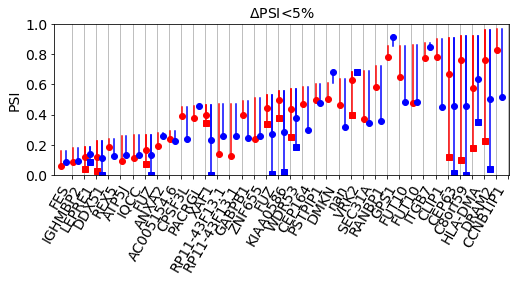

In [10]:
want_see = 'B_LEFT'

plot_snps(want_see)

In [11]:
def plot_four(*arraies):
    # Plotting Params:
    fsize=15
    inds_homo = ((SNP_df.HOMO_COUNTS>=2) & (SNP_df.WT_COUNTS>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
    inds_hetero = ((SNP_df.HETERO_COUNTS>=2) & (SNP_df.WT_COUNTS>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
    

    scaling_factor=1.0
    fig = figure(figsize=(8.5/4*7*scaling_factor,16*scaling_factor))

    model_name = ['HAL','GTEx Joint','Our mer','Our Joint']
    
    homo_dpsi = arraies[-2]
    hetero_dpsi = arraies[-1]
    
    for ii in range(4):
        plot_coor=221+ii
    
        homo_pred = arraies[2*ii]
        hetero_pred = arraies[2*ii+1]
    
        ax = fig.add_subplot(plot_coor)
        
        ax.scatter(hetero_pred,
                   hetero_dpsi,
                   color='r',s=5,label='Heterozygous SNPs')

        ax.scatter(homo_pred,
                   homo_dpsi,
                   color='b',s=5,label='Homozygous SNPs') 
        
        
        
        r2= scipy.stats.pearsonr(np.concatenate((hetero_pred,homo_pred)),
                                 np.concatenate((hetero_dpsi,homo_dpsi)))[0]**2

        pvalue=scipy.stats.pearsonr(np.concatenate((hetero_pred,homo_pred)),
                                 np.concatenate((hetero_dpsi,homo_dpsi)))[1]

        correct = sum(sign(np.concatenate((hetero_pred,homo_pred)))==sign(np.concatenate((hetero_dpsi,homo_dpsi))))
        incorrect = sum(sign(np.concatenate((hetero_pred,homo_pred)))!=sign(np.concatenate((hetero_dpsi,homo_dpsi))))

        f_correct = sum(sign(np.concatenate((hetero_pred[abs(hetero_dpsi)>0.05],homo_pred[abs(homo_dpsi)>0.05])))==sign(np.concatenate((hetero_dpsi[abs(hetero_dpsi)>0.05],homo_dpsi[abs(homo_dpsi)>0.05]))))
        f_incorrect = sum(sign(np.concatenate((hetero_pred[abs(hetero_dpsi)>0.05],homo_pred[abs(homo_dpsi)>0.05])))!=sign(np.concatenate((hetero_dpsi[abs(hetero_dpsi)>0.05],homo_dpsi[abs(homo_dpsi)>0.05]))))
        
        ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
        ax.set_xlabel(model_name[ii],fontsize=fsize)
        ax.tick_params(labelsize=0)
        ax.axis([-1,1,-1,1])
        ax.text(-0.95,0.96,'$R^2$=%0.4f\np-value=%f\n(%d/%d)\n(%d/%d)' %(r2,pvalue,correct,incorrect,f_correct,f_incorrect),fontsize=fsize,ha='left',va='top')
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(y=0,c='k')
        ax.axvline(x=0,c='k')
        ax.tick_params(size=0)


In [12]:
def get_effect_size(donor_pos,wt_seq,mut_seq,model):
    if model=='gtex':
        use_model=gtex_models
        model_num=5
        seq_for_wt =   wt_seq[donor_pos-5000:donor_pos+5000+1]
        seq_for_mut = mut_seq[donor_pos-5000:donor_pos+5000+1]
    
    else:
        use_model=our_models
        model_num=1
        seq_for_wt =   wt_seq[donor_pos-200:donor_pos+200+1]
        seq_for_mut = mut_seq[donor_pos-200:donor_pos+200+1]
    
    
    x_wt = one_hot_encode(seq_for_wt)[None, :]
    y_wt = np.mean([use_model[m].predict(x_wt) for m in range(model_num)], axis=0)[0][0][2]
    
    x_mut = one_hot_encode(seq_for_mut)[None, :]
    y_mut = np.mean([use_model[m].predict(x_mut) for m in range(model_num)], axis=0)[0][0][2]
    
    up=y_mut/(1-y_mut)
    down=y_wt/(1-y_wt)
    
    effect_size = np.log2(up/down)
    
    return effect_size

In [16]:
def get_effect_size_mer(sd1_pos,sd2_pos,wt_seq,mut_seq):
  
    use_model=mer_models
    model_num=1
    seq_for_wt =   wt_seq[sd1_pos-200:sd2_pos+200+1]
    seq_for_mut = mut_seq[sd1_pos-200:sd2_pos+200+1]

    
    x_wt = one_hot_encode(seq_for_wt)[None, :]
    y_wt = np.mean([use_model[m].predict(x_wt) for m in range(model_num)], axis=0)[2,:,:1].sum()/(sd2_pos-sd1_pos+1)
    
    x_mut = one_hot_encode(seq_for_mut)[None, :]
    y_mut = np.mean([use_model[m].predict(x_mut) for m in range(model_num)], axis=0)[2,:,:1].sum()/(sd2_pos-sd1_pos+1)
    
    up=y_mut/(1-y_mut)
    down=y_wt/(1-y_wt)
    
    effect_size = np.log2(up/down)
    
    return effect_size

In [14]:
def effect_to_prob(effect_size, cur_psi):
    homo_pred_element = expit(logit(cur_psi) + effect_size)
    hetero_pred_element = (cur_psi + homo_pred_element)/2.0
    hetero_dpsi_pred = hetero_pred_element-cur_psi
    homo_dpsi_pred = homo_pred_element-cur_psi
    
    return hetero_dpsi_pred, homo_dpsi_pred

In [15]:
from keras.models import load_model
from pkg_resources import resource_filename
from utils2 import one_hot_encode
import numpy as np

our_paths = ('snp_data/a5ss_spliceai14.h5'.format(x) for x in range(1));context1=200
mer_paths = ('snp_data/a3_a5_io_all_many_1.h5'.format(x) for x in range(1));context1=200
# our_paths = ('snp_data/only_a5ss_200_7.h5'.format(x) for x in range(1));context1=100
gtex_paths = ('snp_data/spliceai{}.h5'.format(x) for x in range(1,6));context2=5000

our_models = [load_model(resource_filename('spliceai', x)) for x in our_paths]
mer_models = [load_model(resource_filename('spliceai', x)) for x in mer_paths]
gtex_models = [load_model(resource_filename('spliceai', x)) for x in gtex_paths]



# paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
# models = [load_model(resource_filename('spliceai', x)) for x in paths]


In [17]:
def analysis_figure(want_see):
        
    gtex_joint_homo_list = []
    gtex_joint_hetero_list = []

    hal_homo_list = []
    hal_hetero_list = []
    
    our_mer_homo_list = []
    our_mer_hetero_list = []
    
    our_joint_homo_list = []
    our_joint_hetero_list = []

    


    homo_dpsi_list = []
    hetero_dpsi_list = []
    homo_psi_list = []
    
    
    for i in range(SNP_and_cur_dic['cur_df_'+want_see].shape[0]):
        event=SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['EVENT']
        if event.find(':+@')>0:
            half = event.split(':+@')[0]
            strand='+'
        else:
            half = event.split(':-@')[0]
            strand='-'

        chrom = half.split(':')[0]
        acceptor = half.split(':')[1]
        sd1 = half.split(':')[2].split('|')[0]
        sd2 = half.split(':')[2].split('|')[1]

        
        larger_event = chrom+':'+str(int(sd2)-6000)+'-'+str(int(sd2)+6000)+strand


        if strand=='+':
            sd1e = chrom+':'+str(int(sd1))+'-'+str(int(sd1)+50)+strand
            sd2e = chrom+':'+str(int(sd2))+'-'+str(int(sd2)+50)+strand
            acceptor_event = chrom+':'+str(int(acceptor)-2)+'-'+str(int(acceptor)+50)+strand

        else:
            sd2e = chrom+':'+str(int(sd1)-50)+'-'+str(int(sd1))+strand
            sd1e = chrom+':'+str(int(sd2)-50)+'-'+str(int(sd2))+strand
            acceptor_event = chrom+':'+str(int(acceptor)-50)+'-'+str(int(acceptor)+2)+strand


        loc = locus(larger_event,assembly='hg19')
        full_seq_wt = loc.twoBitFrag().upper()

        snp_pos=full_seq_wt.find(SNP_and_cur_dic['cur_df_'+want_see].iloc[i].WT_SEQ)
        full_seq_mut = full_seq_wt[:snp_pos]+SNP_and_cur_dic['cur_df_'+want_see].iloc[i].MUT_SEQ+full_seq_wt[snp_pos+len(SNP_and_cur_dic['cur_df_'+want_see].iloc[i].MUT_SEQ):]
 
        loc = locus(acceptor_event,assembly='hg19')
        acceptor_seq = loc.twoBitFrag().upper()
        
        
        loc = locus(sd1e,assembly='hg19')
        sd1_seq = loc.twoBitFrag().upper()

        loc = locus(sd2e,assembly='hg19')
        sd2_seq = loc.twoBitFrag().upper()

        acceptor_pos = full_seq_wt.find(acceptor_seq)+2
        sd1_pos = full_seq_wt.find(sd1_seq)
        sd2_pos = full_seq_wt.find(sd2_seq)

        
        
        if sd2_pos - sd1_pos!=SNP_and_cur_dic['cur_df_'+want_see].iloc[i].SD_DIST:
            print('wrong index!!!')

####################################################################################################
        our_sd2_effect_size = get_effect_size(sd2_pos,full_seq_wt,full_seq_mut,'ours')
        our_sd1_effect_size = get_effect_size(sd1_pos,full_seq_wt,full_seq_mut,'ours')

        our_mer_effect_size = get_effect_size_mer(sd1_pos,sd2_pos,full_seq_wt,full_seq_mut)
        
        gtex_sd2_effect_size = get_effect_size(sd2_pos,full_seq_wt,full_seq_mut,'gtex')
        gtex_sd1_effect_size = get_effect_size(sd1_pos,full_seq_wt,full_seq_mut,'gtex')
    
        cur_psi = SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['WT_PSI']
        
        
        
        hal_hetero_element, hal_homo_element = SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['HETERO_DPSI_PRED'] , SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['HOMO_DPSI_PRED']
        
        gtex_joint_hetero_element, gtex_joint_homo_element = effect_to_prob( (gtex_sd2_effect_size-gtex_sd1_effect_size)/2.0 , cur_psi)
        
        our_joint_hetero_element, our_joint_homo_element = effect_to_prob( (our_sd2_effect_size-our_sd1_effect_size)/2.0 , cur_psi)
        
        our_mer_hetero_element, our_mer_homo_element = effect_to_prob( (our_sd2_effect_size-our_sd1_effect_size+our_mer_effect_size)/3.0 , cur_psi)
        
####################################################################################################        
        
        hal_homo_list.append(hal_homo_element)
        hal_hetero_list.append(hal_hetero_element)
        
        gtex_joint_homo_list.append(gtex_joint_homo_element)
        gtex_joint_hetero_list.append(gtex_joint_hetero_element)
        
        our_mer_homo_list.append(our_mer_homo_element)
        our_mer_hetero_list.append(our_mer_hetero_element)
        
        our_joint_homo_list.append(our_joint_homo_element)
        our_joint_hetero_list.append(our_joint_hetero_element)

        

        
        homo_psi_list.append(SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['HOMO_PSI'])
        hetero_dpsi_list.append(SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['HETERO_PSI'] - SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['WT_PSI'])
        homo_dpsi_list.append(SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['HOMO_PSI'] - SNP_and_cur_dic['cur_df_'+want_see].iloc[i]['WT_PSI'])

        
####################################################################################################

    hal_homo_list=np.array(hal_homo_list)
    hal_hetero_list=np.array(hal_hetero_list)

    gtex_joint_homo_list=np.array(gtex_joint_homo_list)
    gtex_joint_hetero_list=np.array(gtex_joint_hetero_list)
    
    our_joint_homo_list=np.array(our_joint_homo_list)
    our_joint_hetero_list=np.array(our_joint_hetero_list)
    
    our_mer_homo_list=np.array(our_mer_homo_list)
    our_mer_hetero_list=np.array(our_mer_hetero_list)


    homo_psi_list=np.array(homo_psi_list)
    hetero_dpsi_list=np.array(hetero_dpsi_list)
    homo_dpsi_list=np.array(homo_dpsi_list) ##
    

    
    hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
    gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
    our_mer_homo_list=our_mer_homo_list[[np.invert(np.isnan(homo_psi_list))]]
    our_joint_homo_list=our_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
    homo_dpsi_list=homo_dpsi_list[np.invert(np.isnan(homo_psi_list))]
    
    
    plot_four(hal_homo_list,hal_hetero_list,
    gtex_joint_homo_list,gtex_joint_hetero_list,
    our_mer_homo_list,our_mer_hetero_list,
    our_joint_homo_list,our_joint_hetero_list,
    homo_dpsi_list,hetero_dpsi_list)

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

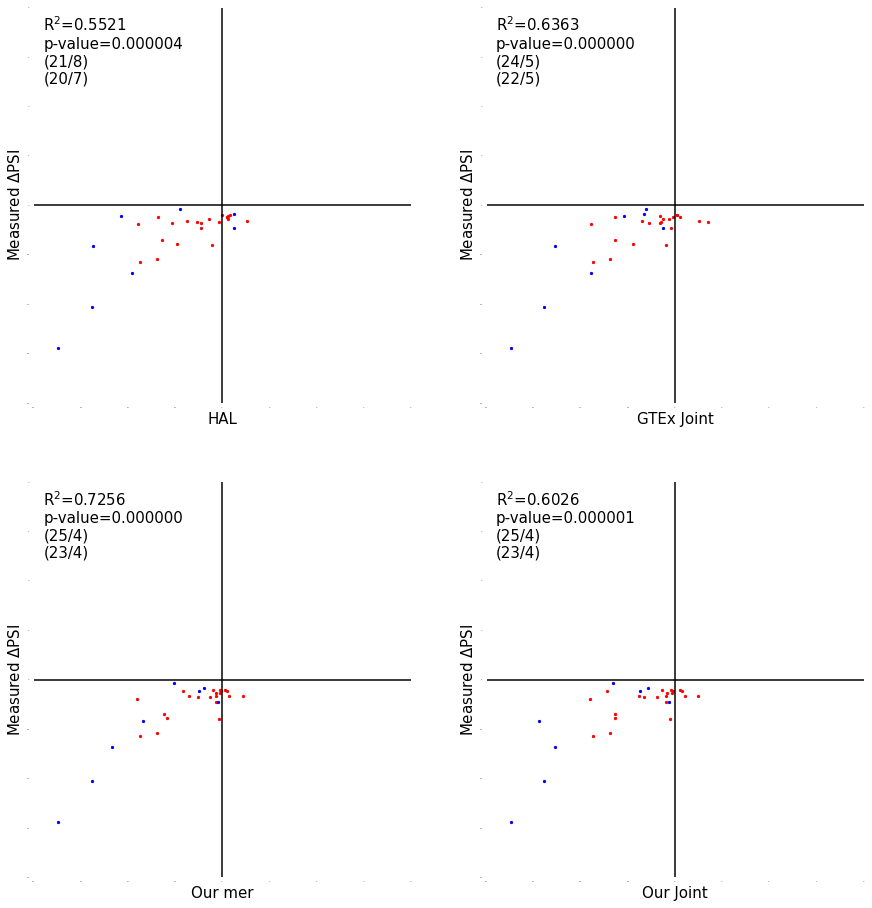

In [19]:
analysis_figure('A_LEFT')

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

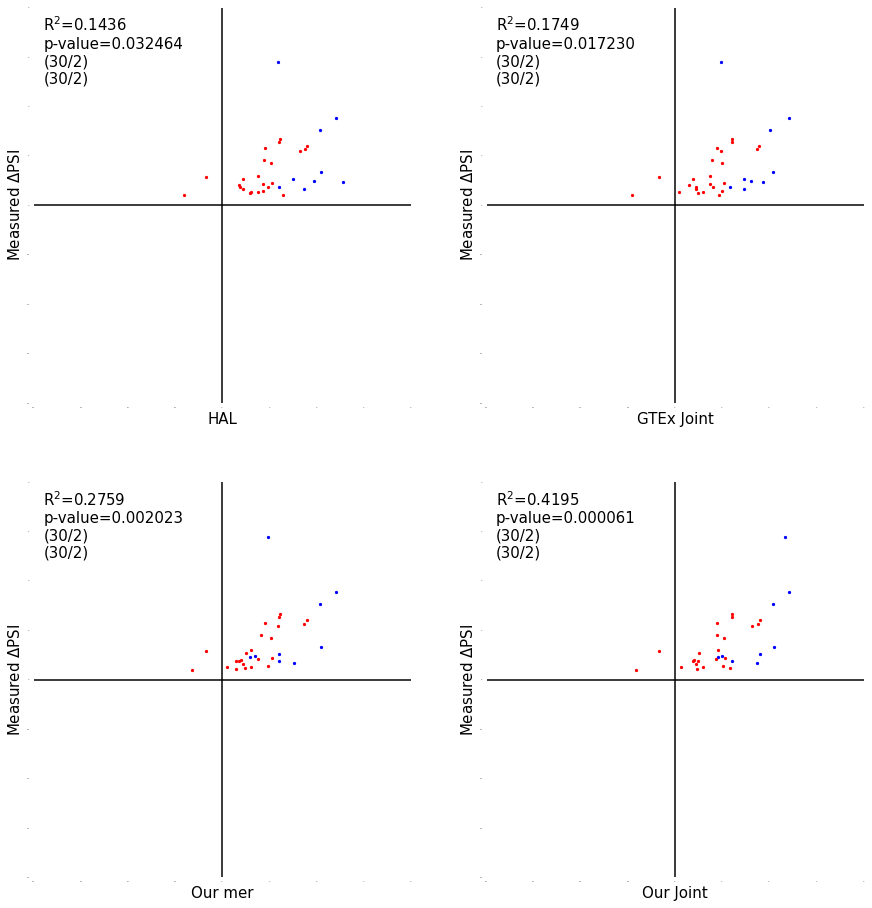

In [20]:
analysis_figure('A_RIGHT')

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

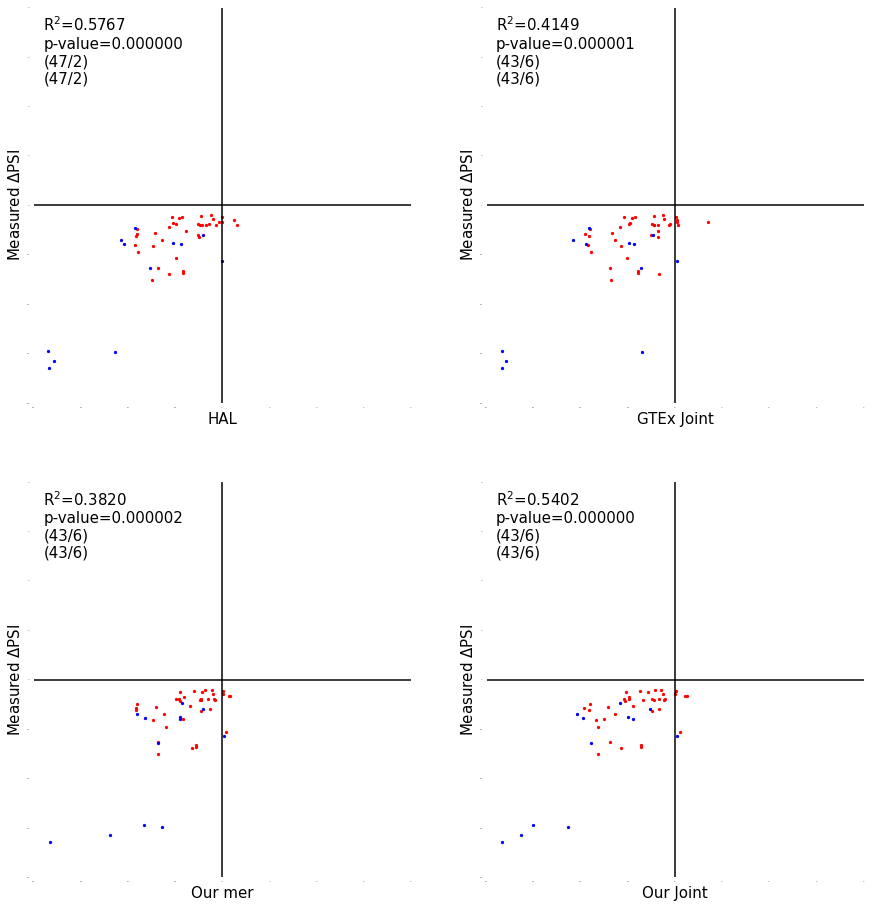

In [21]:
analysis_figure('B_LEFT')

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

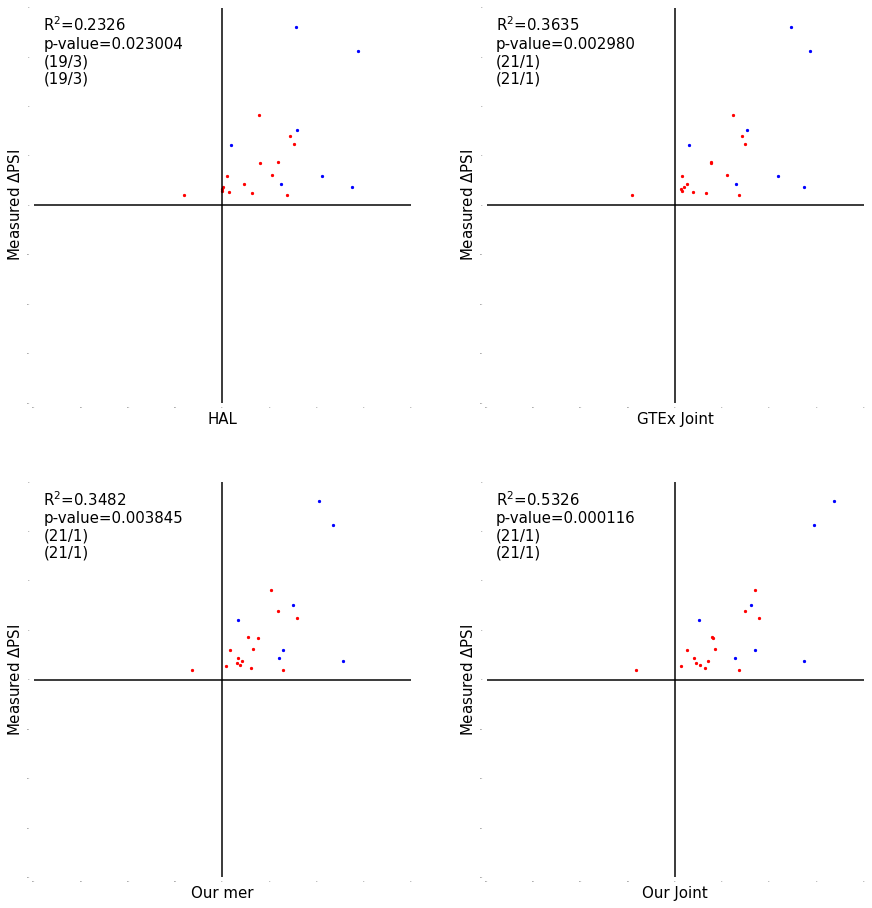

In [22]:
analysis_figure('B_RIGHT')

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

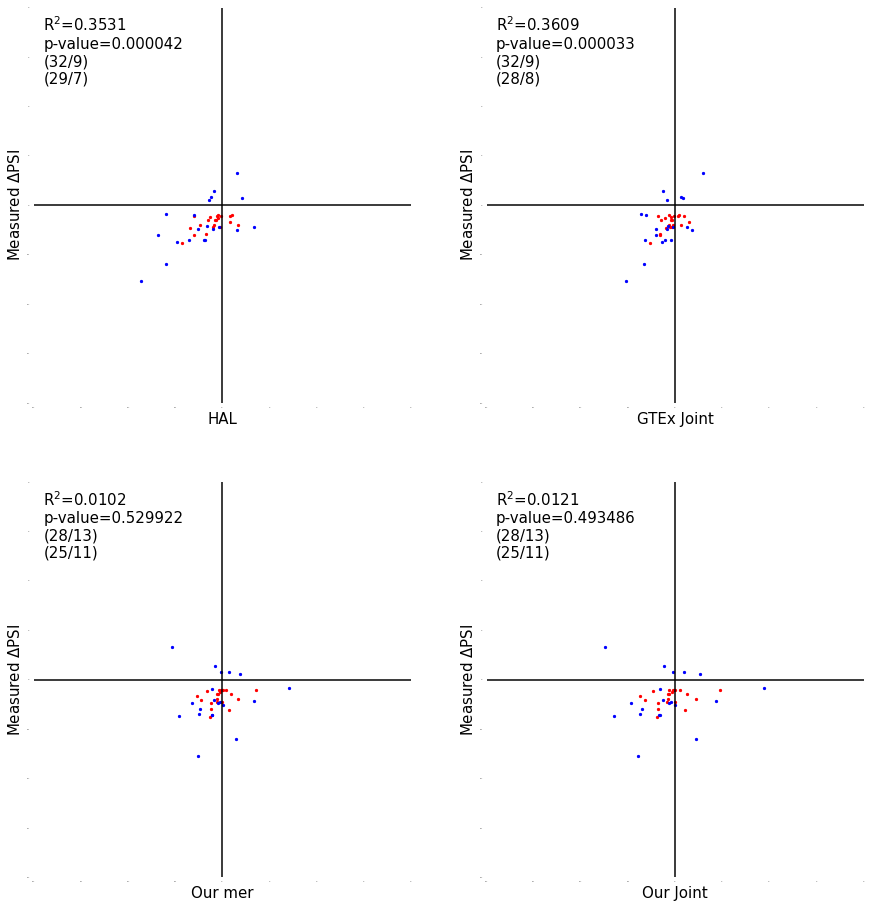

In [23]:
analysis_figure('C_LEFT')

<ipython-input-17-90479cb26e4f>:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hal_homo_list=hal_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gtex_joint_homo_list=gtex_joint_homo_list[[np.invert(np.isnan(homo_psi_list))]]
<ipython-input-17-90479cb26e4f>:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

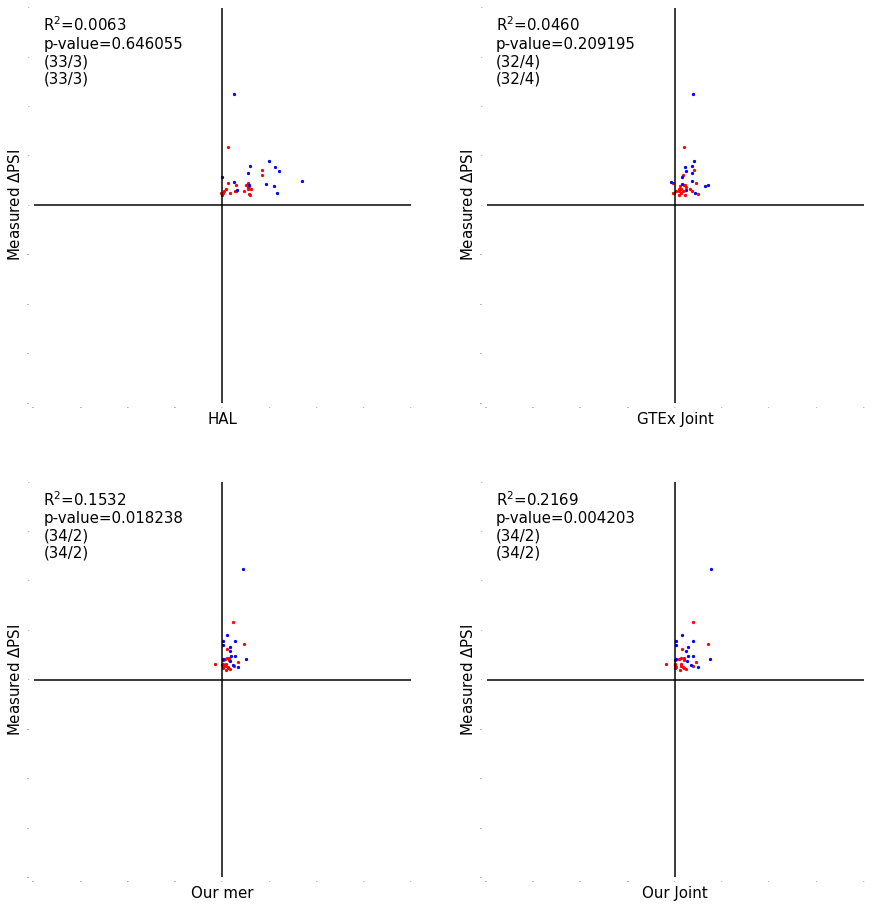

In [24]:
analysis_figure('C_RIGHT')

In [25]:
def view_last_figure(figure_type):
    if figure_type=='AB':
        inds_hetero=[3, 7, 31, 41, 42, 48, 68, 78, 81, 107, 124, 129, 133, 144, 165, 167, 169, 185, 205, 207, 211, 237, 248, 249, 250, 251, 255, 257, 275, 287, 290, 294, 338, 339, 353, 363, 385, 400, 416, 430, 440, 468, 469, 475, 478, 480, 499, 516, 564, 565, 580, 601, 609, 622, 631, 638, 643, 670, 679, 690, 700, 701, 711, 712, 714, 715, 722, 759, 771, 785, 786, 791, 794, 797, 808, 812, 823, 836, 844, 847, 852, 860, 863, 869, 875, 883, 887, 902, 918, 921, 926, 944, 950, 954, 955, 962, 983, 992, 1029, 1031, 1047, 1048, 1052, 1059, 1060, 1067, 1081, 1091, 1098, 1099, 1102, 1105, 1111, 1114, 1115, 1117, 1127, 1137, 1144, 1169, 1172, 1173, 1179, 1183, 1199, 1207, 1213, 1233, 1264, 1279, 1296, 1319, 1320, 1333, 1345, 1350, 1365, 1376, 1389, 1399, 1414, 1431, 1437, 1449, 1452, 1468, 1477, 1489, 1490, 1492, 1499, 1523, 1533, 1534, 1536, 1542, 1549, 1567, 1569, 1574, 1576, 1577, 1578, 1589, 1591, 1594, 1601, 1602, 1622, 1627, 1633, 1644, 1679, 1689, 1715, 1722, 1725, 1727, 1729, 1731, 1747, 1759, 1770, 1771, 1781, 1786, 1792, 1793, 1797, 1812, 1815, 1824, 1838, 1842, 1880, 1884, 1928, 1929, 1951]
        inds_homo=[3, 41, 42, 144, 167, 169, 211, 237, 275, 290, 294, 339, 363, 416, 564, 580, 601, 622, 643, 690, 700, 701, 722, 786, 791, 797, 808, 812, 883, 954, 955, 962, 992, 1029, 1060, 1098, 1105, 1137, 1144, 1333, 1350, 1414, 1468, 1492, 1533, 1536, 1542, 1549, 1574, 1576, 1589, 1601, 1622, 1633, 1689, 1715, 1759, 1792, 1793, 1812, 1815, 1838, 1884, 1951]
        
    elif figure_type=='C':
        inds_hetero = [9, 19, 20, 25, 33, 34, 40, 49, 51, 57, 58, 59, 60, 77, 80, 82, 83, 92, 93, 104, 112, 114, 115, 116, 117, 119, 126, 127, 137, 156, 170, 192, 195, 197, 198, 202, 209, 223, 234, 241, 243, 252, 253, 256, 258, 264, 265, 268, 269, 274, 302, 307, 321, 323, 324, 326, 327, 331, 336, 340, 347, 351, 354, 357, 361, 365, 366, 369, 380, 381, 387, 389, 398, 413, 415, 417, 418, 437, 439, 444, 445, 449, 452, 453, 456, 459, 460, 462, 463, 464, 465, 493, 500, 501, 510, 524, 525, 529, 530, 531, 537, 547, 548, 552, 559, 561, 563, 567, 578, 582, 592, 593, 596, 600, 602, 610, 630, 637, 645, 657, 660, 661, 662, 684, 692, 698, 699, 703, 704, 705, 706, 710, 713, 716, 736, 738, 740, 743, 744, 749, 752, 755, 760, 767, 773, 774, 790, 798, 804, 805, 809, 817, 819, 824, 829, 838, 840, 854, 855, 861, 864, 867, 871, 872, 874, 878, 884, 886, 890, 891, 894, 915, 920, 932, 942, 947, 953, 960, 965, 968, 975, 976, 990, 991, 1006, 1008, 1009, 1017, 1020, 1024, 1025, 1037, 1040, 1044, 1045, 1049, 1063, 1078, 1082, 1084, 1085, 1093, 1113, 1138, 1139, 1143, 1150, 1156, 1161, 1164, 1190, 1200, 1203, 1204, 1205, 1206, 1212, 1216, 1225, 1239, 1240, 1241, 1243, 1244, 1270, 1291, 1293, 1295, 1304, 1305, 1308, 1309, 1311, 1329, 1330, 1331, 1346, 1347, 1352, 1355, 1356, 1363, 1364, 1366, 1378, 1390, 1393, 1396, 1398, 1401, 1404, 1417, 1426, 1427, 1438, 1454, 1455, 1464, 1473, 1474, 1475, 1480, 1481, 1482, 1485, 1494, 1506, 1507, 1519, 1521, 1531, 1532, 1554, 1556, 1557, 1558, 1564, 1566, 1572, 1575, 1583, 1585, 1587, 1593, 1596, 1610, 1619, 1641, 1643, 1651, 1667, 1683, 1690, 1698, 1700, 1705, 1706, 1707, 1713, 1719, 1738, 1755, 1757, 1761, 1763, 1766, 1775, 1778, 1783, 1788, 1806, 1817, 1820, 1821, 1823, 1825, 1829, 1831, 1832, 1852, 1853, 1855, 1857, 1862, 1864, 1865, 1866, 1867, 1868, 1898, 1899, 1907, 1908, 1911, 1919, 1924, 1925, 1926, 1936, 1938, 1948, 1952, 1953, 1954]
        inds_homo = [9, 25, 40, 51, 80, 83, 112, 114, 115, 116, 117, 119, 126, 170, 192, 195, 197, 241, 243, 264, 265, 268, 269, 274, 307, 321, 324, 327, 336, 340, 347, 357, 361, 365, 369, 389, 415, 417, 418, 500, 501, 529, 530, 578, 582, 602, 630, 657, 660, 710, 713, 716, 760, 790, 817, 819, 854, 855, 872, 874, 890, 891, 894, 953, 960, 968, 975, 976, 990, 991, 1020, 1037, 1044, 1049, 1063, 1078, 1139, 1143, 1156, 1161, 1200, 1212, 1216, 1225, 1239, 1240, 1270, 1308, 1309, 1346, 1347, 1352, 1366, 1378, 1393, 1404, 1417, 1427, 1464, 1475, 1481, 1494, 1507, 1531, 1557, 1558, 1564, 1572, 1575, 1641, 1643, 1683, 1705, 1706, 1707, 1713, 1761, 1766, 1817, 1832, 1852, 1853, 1855, 1862, 1868, 1898, 1907, 1908, 1952, 1953, 1954]
        
    elif figure_type=='ABC':
        inds_hetero=[3, 7, 31, 41, 42, 48, 68, 78, 81, 107, 124, 129, 133, 144, 165, 167, 169, 185, 205, 207, 211, 237, 248, 249, 250, 251, 255, 257, 275, 287, 290, 294, 338, 339, 353, 363, 385, 400, 416, 430, 440, 468, 469, 475, 478, 480, 499, 516, 564, 565, 580, 601, 609, 622, 631, 638, 643, 670, 679, 690, 700, 701, 711, 712, 714, 715, 722, 759, 771, 785, 786, 791, 794, 797, 808, 812, 823, 836, 844, 847, 852, 860, 863, 869, 875, 883, 887, 902, 918, 921, 926, 944, 950, 954, 955, 962, 983, 992, 1029, 1031, 1047, 1048, 1052, 1059, 1060, 1067, 1081, 1091, 1098, 1099, 1102, 1105, 1111, 1114, 1115, 1117, 1127, 1137, 1144, 1169, 1172, 1173, 1179, 1183, 1199, 1207, 1213, 1233, 1264, 1279, 1296, 1319, 1320, 1333, 1345, 1350, 1365, 1376, 1389, 1399, 1414, 1431, 1437, 1449, 1452, 1468, 1477, 1489, 1490, 1492, 1499, 1523, 1533, 1534, 1536, 1542, 1549, 1567, 1569, 1574, 1576, 1577, 1578, 1589, 1591, 1594, 1601, 1602, 1622, 1627, 1633, 1644, 1679, 1689, 1715, 1722, 1725, 1727, 1729, 1731, 1747, 1759, 1770, 1771, 1781, 1786, 1792, 1793, 1797, 1812, 1815, 1824, 1838, 1842, 1880, 1884, 1928, 1929, 1951]+[9, 19, 20, 25, 33, 34, 40, 49, 51, 57, 58, 59, 60, 77, 80, 82, 83, 92, 93, 104, 112, 114, 115, 116, 117, 119, 126, 127, 137, 156, 170, 192, 195, 197, 198, 202, 209, 223, 234, 241, 243, 252, 253, 256, 258, 264, 265, 268, 269, 274, 302, 307, 321, 323, 324, 326, 327, 331, 336, 340, 347, 351, 354, 357, 361, 365, 366, 369, 380, 381, 387, 389, 398, 413, 415, 417, 418, 437, 439, 444, 445, 449, 452, 453, 456, 459, 460, 462, 463, 464, 465, 493, 500, 501, 510, 524, 525, 529, 530, 531, 537, 547, 548, 552, 559, 561, 563, 567, 578, 582, 592, 593, 596, 600, 602, 610, 630, 637, 645, 657, 660, 661, 662, 684, 692, 698, 699, 703, 704, 705, 706, 710, 713, 716, 736, 738, 740, 743, 744, 749, 752, 755, 760, 767, 773, 774, 790, 798, 804, 805, 809, 817, 819, 824, 829, 838, 840, 854, 855, 861, 864, 867, 871, 872, 874, 878, 884, 886, 890, 891, 894, 915, 920, 932, 942, 947, 953, 960, 965, 968, 975, 976, 990, 991, 1006, 1008, 1009, 1017, 1020, 1024, 1025, 1037, 1040, 1044, 1045, 1049, 1063, 1078, 1082, 1084, 1085, 1093, 1113, 1138, 1139, 1143, 1150, 1156, 1161, 1164, 1190, 1200, 1203, 1204, 1205, 1206, 1212, 1216, 1225, 1239, 1240, 1241, 1243, 1244, 1270, 1291, 1293, 1295, 1304, 1305, 1308, 1309, 1311, 1329, 1330, 1331, 1346, 1347, 1352, 1355, 1356, 1363, 1364, 1366, 1378, 1390, 1393, 1396, 1398, 1401, 1404, 1417, 1426, 1427, 1438, 1454, 1455, 1464, 1473, 1474, 1475, 1480, 1481, 1482, 1485, 1494, 1506, 1507, 1519, 1521, 1531, 1532, 1554, 1556, 1557, 1558, 1564, 1566, 1572, 1575, 1583, 1585, 1587, 1593, 1596, 1610, 1619, 1641, 1643, 1651, 1667, 1683, 1690, 1698, 1700, 1705, 1706, 1707, 1713, 1719, 1738, 1755, 1757, 1761, 1763, 1766, 1775, 1778, 1783, 1788, 1806, 1817, 1820, 1821, 1823, 1825, 1829, 1831, 1832, 1852, 1853, 1855, 1857, 1862, 1864, 1865, 1866, 1867, 1868, 1898, 1899, 1907, 1908, 1911, 1919, 1924, 1925, 1926, 1936, 1938, 1948, 1952, 1953, 1954]
        inds_homo=[3, 41, 42, 144, 167, 169, 211, 237, 275, 290, 294, 339, 363, 416, 564, 580, 601, 622, 643, 690, 700, 701, 722, 786, 791, 797, 808, 812, 883, 954, 955, 962, 992, 1029, 1060, 1098, 1105, 1137, 1144, 1333, 1350, 1414, 1468, 1492, 1533, 1536, 1542, 1549, 1574, 1576, 1589, 1601, 1622, 1633, 1689, 1715, 1759, 1792, 1793, 1812, 1815, 1838, 1884, 1951]+[9, 25, 40, 51, 80, 83, 112, 114, 115, 116, 117, 119, 126, 170, 192, 195, 197, 241, 243, 264, 265, 268, 269, 274, 307, 321, 324, 327, 336, 340, 347, 357, 361, 365, 369, 389, 415, 417, 418, 500, 501, 529, 530, 578, 582, 602, 630, 657, 660, 710, 713, 716, 760, 790, 817, 819, 854, 855, 872, 874, 890, 891, 894, 953, 960, 968, 975, 976, 990, 991, 1020, 1037, 1044, 1049, 1063, 1078, 1139, 1143, 1156, 1161, 1200, 1212, 1216, 1225, 1239, 1240, 1270, 1308, 1309, 1346, 1347, 1352, 1366, 1378, 1393, 1404, 1417, 1427, 1464, 1475, 1481, 1494, 1507, 1531, 1557, 1558, 1564, 1572, 1575, 1641, 1643, 1683, 1705, 1706, 1707, 1713, 1761, 1766, 1817, 1832, 1852, 1853, 1855, 1862, 1868, 1898, 1907, 1908, 1952, 1953, 1954]
        
    else:
        print("please check your figure type")
        return
    
    
    
    hal_homo_list = []
    hal_hetero_list = []

    gtex_joint_homo_list = []
    gtex_joint_hetero_list = []

    our_mer_homo_list = []
    our_mer_hetero_list = []

    our_joint_homo_list = []
    our_joint_hetero_list = []


    homo_dpsi_list = []
    hetero_dpsi_list = []
    homo_psi_list = []

    has_homo=[]


    for i in inds_hetero:

        has_homo.append(i in inds_homo)

        event=SNP_df.iloc[i]['EVENT']
        if event.find(':+@')>0:
            half = event.split(':+@')[0]
            strand='+'
        else:
            half = event.split(':-@')[0]
            strand='-'

        chrom = half.split(':')[0]
        acceptor = half.split(':')[1]
        sd1 = half.split(':')[2].split('|')[0]
        sd2 = half.split(':')[2].split('|')[1]

        larger_event = chrom+':'+str(int(sd2)-6000)+'-'+str(int(sd2)+6000)+strand


        if strand=='+':
            sd1e = chrom+':'+str(int(sd1))+'-'+str(int(sd1)+50)+strand
            sd2e = chrom+':'+str(int(sd2))+'-'+str(int(sd2)+50)+strand

        else:
            sd2e = chrom+':'+str(int(sd1)-50)+'-'+str(int(sd1))+strand
            sd1e = chrom+':'+str(int(sd2)-50)+'-'+str(int(sd2))+strand


        loc = locus(larger_event,assembly='hg19')
        full_seq_wt = loc.twoBitFrag().upper()

        snp_pos=full_seq_wt.find(SNP_df.iloc[i].WT_SEQ)
        full_seq_mut = full_seq_wt[:snp_pos]+SNP_df.iloc[i].MUT_SEQ+full_seq_wt[snp_pos+len(SNP_df.iloc[i].MUT_SEQ):]

        loc = locus(sd1e,assembly='hg19')
        sd1_seq = loc.twoBitFrag().upper()

        loc = locus(sd2e,assembly='hg19')
        sd2_seq = loc.twoBitFrag().upper()

        sd1_pos = full_seq_wt.find(sd1_seq)
        sd2_pos = full_seq_wt.find(sd2_seq)

        if sd2_pos - sd1_pos!=SNP_df.iloc[i].SD_DIST:
            print('wrong index!!!')

    ####################################################################################################
        our_sd2_effect_size = get_effect_size(sd2_pos,full_seq_wt,full_seq_mut,'ours')
        our_sd1_effect_size = get_effect_size(sd1_pos,full_seq_wt,full_seq_mut,'ours')

        our_mer_effect_size = get_effect_size_mer(sd1_pos,sd2_pos,full_seq_wt,full_seq_mut)

        gtex_sd2_effect_size = get_effect_size(sd2_pos,full_seq_wt,full_seq_mut,'gtex')
        gtex_sd1_effect_size = get_effect_size(sd1_pos,full_seq_wt,full_seq_mut,'gtex')

        cur_psi = SNP_df.iloc[i]['WT_PSI']


        hal_hetero_element, hal_homo_element = SNP_df.iloc[i]['HETERO_DPSI_PRED'], SNP_df.iloc[i]['HOMO_DPSI_PRED']

        gtex_joint_hetero_element, gtex_joint_homo_element = effect_to_prob( (gtex_sd2_effect_size-gtex_sd1_effect_size)/2.0 , cur_psi)

        our_joint_hetero_element, our_joint_homo_element = effect_to_prob( (our_sd2_effect_size-our_sd1_effect_size)/2.0 , cur_psi)

        our_mer_hetero_element, our_mer_homo_element = effect_to_prob( (our_sd2_effect_size-our_sd1_effect_size+our_mer_effect_size)/3.0 , cur_psi)




        hal_homo_list.append(hal_homo_element)
        hal_hetero_list.append(hal_hetero_element)

        gtex_joint_homo_list.append(gtex_joint_homo_element)
        gtex_joint_hetero_list.append(gtex_joint_hetero_element)

        our_mer_homo_list.append(our_mer_homo_element)
        our_mer_hetero_list.append(our_mer_hetero_element)

        our_joint_homo_list.append(our_joint_homo_element)
        our_joint_hetero_list.append(our_joint_hetero_element)



        homo_psi_list.append(SNP_df.iloc[i]['HOMO_PSI'])
        hetero_dpsi_list.append(SNP_df.iloc[i]['HETERO_PSI'] - SNP_df.iloc[i]['WT_PSI'])
        homo_dpsi_list.append(SNP_df.iloc[i]['HOMO_PSI'] - SNP_df.iloc[i]['WT_PSI'])


    ####################################################################################################     


    hal_homo_list=np.array(hal_homo_list)
    hal_hetero_list=np.array(hal_hetero_list)

    gtex_joint_homo_list=np.array(gtex_joint_homo_list)
    gtex_joint_hetero_list=np.array(gtex_joint_hetero_list)

    our_joint_homo_list=np.array(our_joint_homo_list)
    our_joint_hetero_list=np.array(our_joint_hetero_list)

    our_mer_homo_list=np.array(our_mer_homo_list)
    our_mer_hetero_list=np.array(our_mer_hetero_list)


    hetero_dpsi_list=np.array(hetero_dpsi_list)
    homo_dpsi_list=np.array(homo_dpsi_list) ##

    has_homo=np.array(has_homo)





    hal_homo_list=hal_homo_list[has_homo]
    gtex_joint_homo_list=gtex_joint_homo_list[has_homo]
    our_mer_homo_list=our_mer_homo_list[has_homo]
    our_joint_homo_list=our_joint_homo_list[has_homo]
    homo_dpsi_list=homo_dpsi_list[has_homo]

    plot_four(
    hal_homo_list,hal_hetero_list,
    gtex_joint_homo_list,gtex_joint_hetero_list,
    our_mer_homo_list,our_mer_hetero_list,
    our_joint_homo_list,our_joint_hetero_list,
    homo_dpsi_list,hetero_dpsi_list)

### Figure 6. A+B (S4 A)

<ipython-input-3-ecfd4133c847>:10: RuntimeWarning: divide by zero encountered in log
  logit = lambda x: np.log(x)-np.log(1-x)


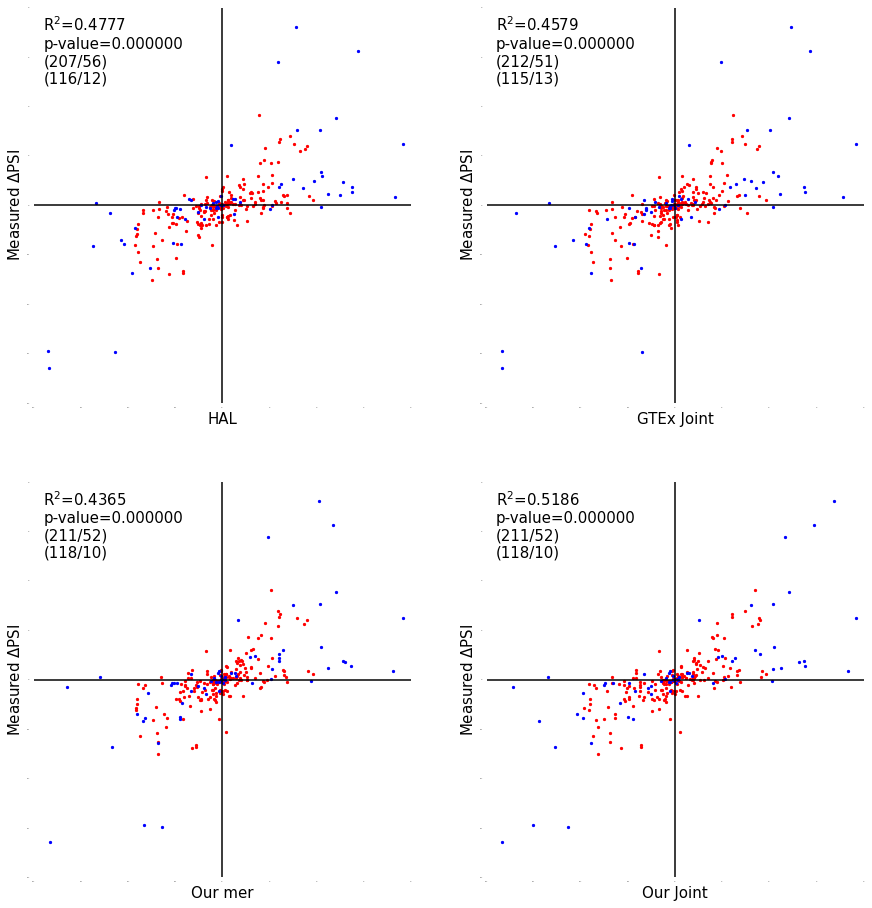

In [26]:
view_last_figure('AB')

### Figure 6. C

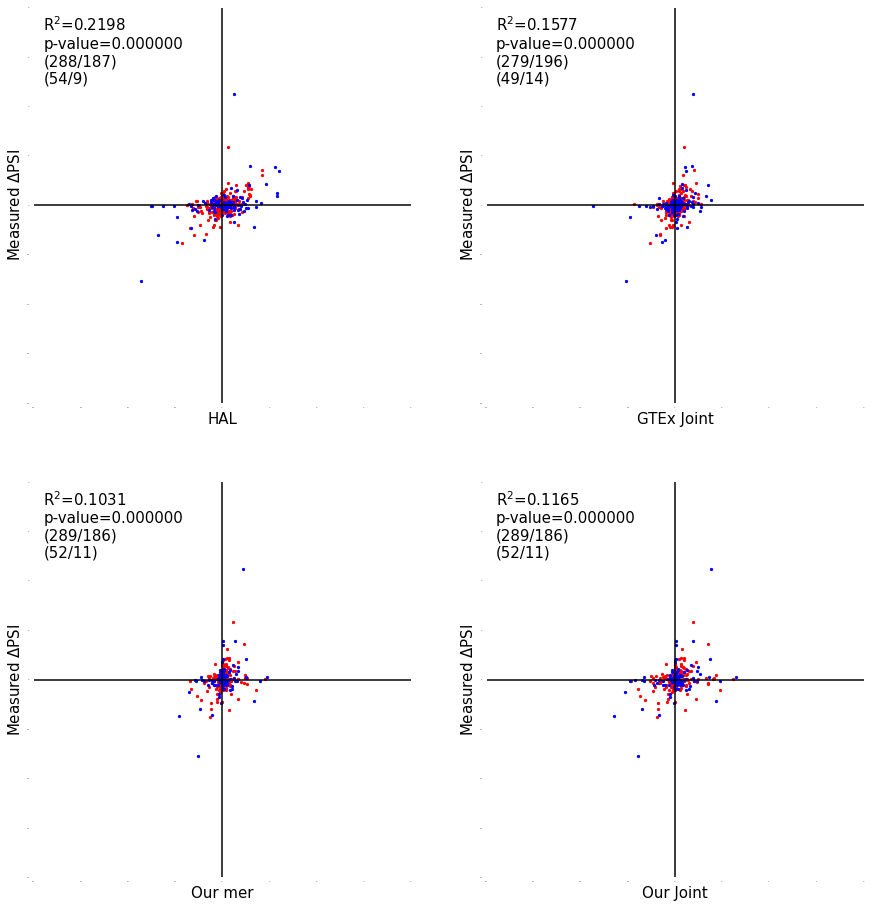

In [27]:
view_last_figure('C')

### Figure 6. A+B+C

<ipython-input-3-ecfd4133c847>:10: RuntimeWarning: divide by zero encountered in log
  logit = lambda x: np.log(x)-np.log(1-x)


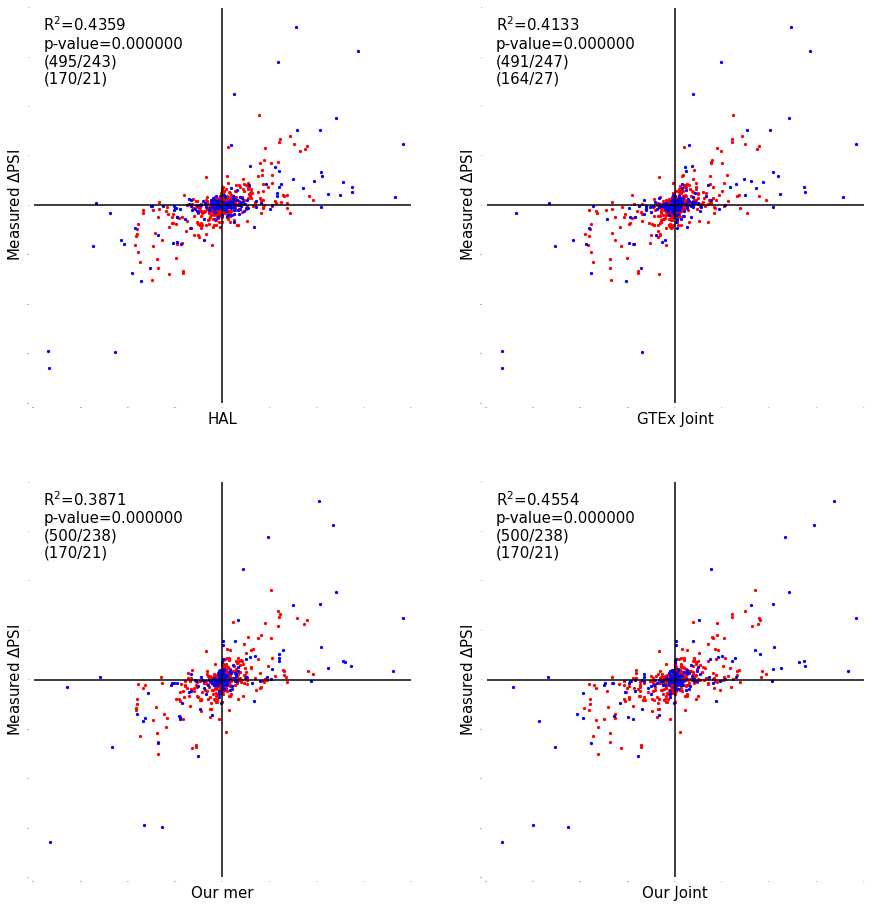

In [28]:
view_last_figure('ABC')